In [1]:
# author: Leonardo Filipe
# webiste: https://www.leonardofilipe.com
# contact: contact@leonardofilipe.com
import io
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

In [2]:
tickers = ['%5EGSPTSE','%5EGSPC','%5ESTOXX','000001.SS']

data = None
while data is None:
    try:
        data = getdata(tickers,'946616400','1538280000','1d')
    except:
         pass

data['%5EGSPC']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,1464.469971,1472.420044,1458.189941,1469.250000,1469.250000,374050000
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000
2000-01-11,1457.599976,1458.660034,1434.420044,1438.560059,1438.560059,1014000000
2000-01-12,1438.560059,1442.599976,1427.079956,1432.250000,1432.250000,974600000


In [3]:
boughtSP = float(data['%5EGSPC']['Adj Close'][:1])
soldSP = data['%5EGSPC']['Adj Close']
BuyHoldSP = soldSP/boughtSP-1

boughtTSX = float(data['%5EGSPTSE']['Adj Close'][:1])
soldTSX = data['%5EGSPTSE']['Adj Close']
BuyHoldTSX = soldTSX/boughtTSX-1

boughtSTOXX = float(data['%5ESTOXX']['Adj Close'][:1])
soldSTOXX = data['%5ESTOXX']['Adj Close']
BuyHoldSTOXX = soldSTOXX/boughtSTOXX-1

boughtSSE = float(data['000001.SS']['Adj Close'][:1])
soldSSE = data['000001.SS']['Adj Close']
BuyHoldSSE = soldSSE/boughtSSE-1

BuyHoldAll = BuyHoldSP*(1/4)+BuyHoldTSX*(1/4)+BuyHoldSTOXX*(1/4)+BuyHoldSSE*(1/4)

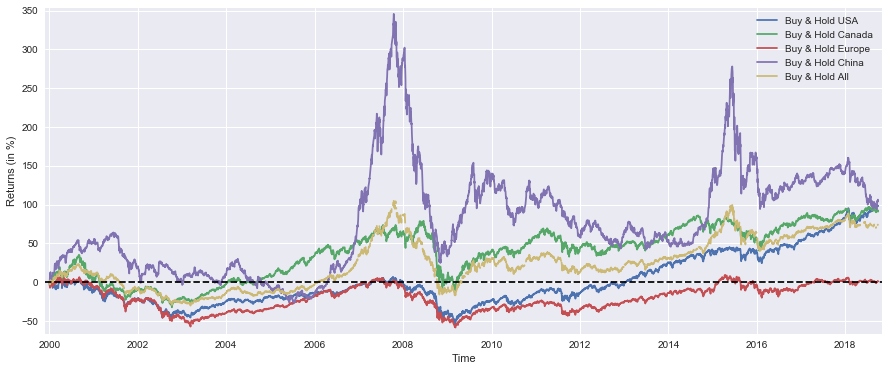

In [4]:
plt.figure(figsize=(15,6))
#=============================================================================================
plt.plot(BuyHoldSP*100, label='Buy & Hold USA')
plt.plot(BuyHoldTSX*100, label='Buy & Hold Canada')
plt.plot(BuyHoldSTOXX*100, label='Buy & Hold Europe')
plt.plot(BuyHoldSSE*100, label='Buy & Hold China')
plt.plot(BuyHoldAll*100, label='Buy & Hold All')
# if you wish to hide a graph add # before the code of the respective graph
#=============================================================================================
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [5]:
bought1ySP = data['%5EGSPC']['Adj Close'].shift(252)
sold1ySP = data['%5EGSPC']['Adj Close']
BuyHold1ySP = sold1ySP/bought1ySP-1

bought1yTSX = data['%5EGSPTSE']['Adj Close'].shift(252)
sold1yTSX = data['%5EGSPTSE']['Adj Close']
BuyHold1yTSX = sold1yTSX/bought1yTSX-1

bought1ySTOXX = data['%5ESTOXX']['Adj Close'].shift(252)
sold1ySTOXX = data['%5ESTOXX']['Adj Close']
BuyHold1ySTOXX = sold1ySTOXX/bought1ySTOXX-1

bought1ySSE = data['000001.SS']['Adj Close'].shift(252)
sold1ySSE = data['000001.SS']['Adj Close']
BuyHold1ySSE = sold1ySSE/bought1ySSE-1

BuyHold1yAll = BuyHold1ySP*(1/4)+BuyHold1yTSX*(1/4)+BuyHold1ySTOXX*(1/4)+BuyHold1ySSE*(1/4)

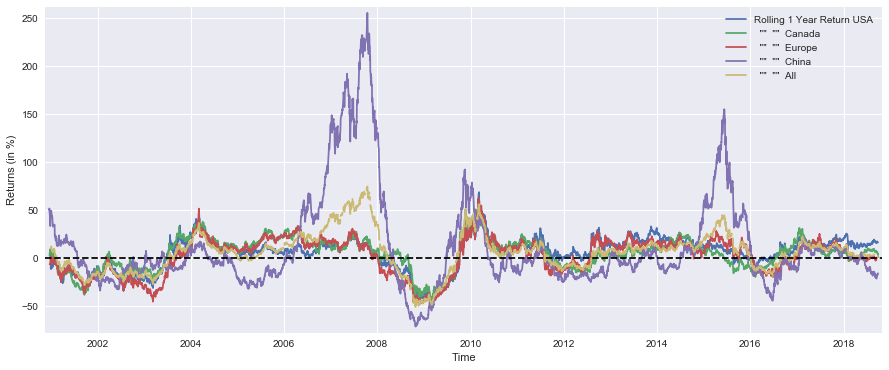

In [6]:
plt.figure(figsize=(15,6))
#=============================================================================================
plt.plot(BuyHold1ySP*100, label='Rolling 1 Year Return USA')
plt.plot(BuyHold1yTSX*100, label='  ""  ""  Canada')
plt.plot(BuyHold1ySTOXX*100, label='  ""  ""  Europe')
plt.plot(BuyHold1ySSE*100, label='  ""  ""  China')
plt.plot(BuyHold1yAll*100, label='  ""  ""  All')
# if you wish to hide a graph add # before the code of the respective graph
#=============================================================================================
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [7]:
riskfree = 0
SP1YS = (BuyHold1ySP.mean()-riskfree)/BuyHold1ySP.std()
TSX1YS = (BuyHold1yTSX.mean()-riskfree)/BuyHold1yTSX.std()
STOXX1YS = (BuyHold1ySTOXX.mean()-riskfree)/BuyHold1ySTOXX.std()
SSE1YS = (BuyHold1ySSE.mean()-riskfree)/BuyHold1ySSE.std()
All1YS = (BuyHold1yAll.mean()-riskfree)/BuyHold1yAll.std()

print('SP500 Buy & Hold 1 Year Sharpe Ratio = ',round(SP1YS,2))
print('TSX "" "" = ',round(TSX1YS,2))
print('STOXX600 "" "" = ',round(STOXX1YS,2))
print('SSE "" "" = ',round(SSE1YS,2))
print('All "" "" = ',round(All1YS,2))

SP500 Buy & Hold 1 Year Sharpe Ratio =  0.31
TSX "" "" =  0.26
STOXX600 "" "" =  0.11
SSE "" "" =  0.22
All "" "" =  0.26
